In [1]:
from Test_UKF_ode import f_odes #Mahlzeit t=0, keine Adaptation von Parametern
from Test_UKF_ode_2 import f_odes_2 #Mahlzeit t=0, erlaubt Adaptation von Parametern k1, k5, tau_g
from Test_UKF_solver import f_solve #Solver für f_odes und f_odes_2
from Test_UKF_pyUKF import UKFException, UKF
from Test_UKF_ode_Dt_sim import f_odes_Dt_sim #erlaubt Simulationen mit Mahlzeiteneingaben zu unterschiedlichen Zeitpunkten
from Test_UKF_solver_Dt import f_solve_Dt #Solver für f_odes_Dt_sim
from Test_UKF_ode_Dt_par import f_odes_Dt_par #erlaubt die Eingabe vom Literaturwert abweichender Parameter k1, k5, tau_g

import Test_UKF_params as param #Gleichungsparameter, Literaturwerte
import numpy as np
import matplotlib.pyplot as plt

## UKF Schätzung der 4 Modellzustände ohne Parameterschätzung

#### A) 4 Modellzustände, D_meal zum Zeitpunkt 0 (Nüchternzustand)

#### Simulation von Testdaten

In [2]:
t_eval = np.arange(1,24*3600+2,300)
D = 75000 #KH-Gehalt einer Mahlzeit
D_inputs = np.zeros(shape=(len(t_eval))) #leeres Array zum Einfügen von Mahlzeiteninputs
D_inputs[13] = 75000 #Mahlzeitengabe in Array einfügen
D_mealtime = np.column_stack((t_eval, D_inputs))
D_mealtime[13]

array([ 3901., 75000.])

In [3]:
G_start = param.G_pl_b #Startwert basale Glukose
I_start = param.I_pl_b #Startwert basales Insulin

In [4]:
noise = np.random.normal(0, 0.2, len(t_eval)) #Normalverteiltes Rauschen

#MARD = 8-9%, 99% Messgenauigkeit (https://www.researchgate.net/publication/358601178_Accuracy_and_Safety_of_Dexcom_G7_Continuous_Glucose_Monitoring_in_Adults_with_Diabetes
#T = z*sigma: Trel = 0.3 --> sigma_rel = 0.3/2.576 --> ungefähr 0.1
noise2 = np.random.normal(0, 0.1, len(t_eval)) #Normalverteiltes Rauschen, angepasste Schätzung

In [5]:
#Array mit Startzuständen der Simulation

y_init = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start #G_i_start
                 ]) 

In [6]:
sim = f_solve_Dt(f_odes_Dt_sim, y_init, D_mealtime) #Erstellen von Simulationsdaten

In [7]:
sim[-1] #Überprüfen Format der Simulationsdaten

array([-5.57907605e-11,  5.24000000e+00,  6.50000000e+00,  5.24000000e+00])

In [8]:
len(noise2), len(sim[:,3]), len(t_eval)

(289, 289, 289)

In [9]:
sim[:,3]+=noise2 #den simulierten CGM-Daten Rauschen hinzufügen

In [10]:
# Erzeugen eines Datensets mit 3-Spalten für den UKF
# sim_data_set[0]: Zeit in s, sim_data_set[1]: simulierte CGM-Daten, sim_data_set[2]: Mahlzeiteninputs

t_eval # Zeit in s
cgm_data = sim[:,3] #simulierte CGM-Daten auslesen
sim_data = np.column_stack((t_eval, cgm_data, D_inputs)) #Datenset zur Übergabe an UKF

In [11]:
sim_data[12], sim_data[13]

(array([3601.        ,    5.45348281,    0.        ]),
 array([3.90100000e+03, 5.26530868e+00, 7.50000000e+04]))

In [12]:
len(sim_data)

289

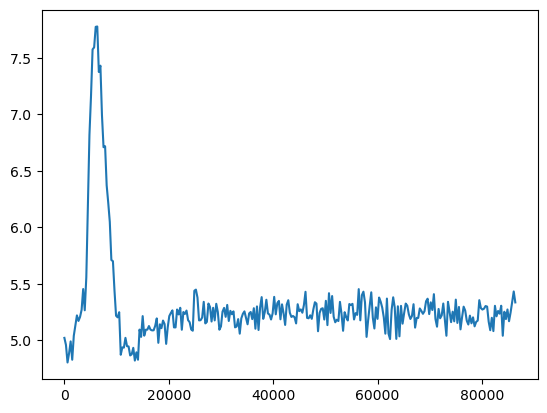

In [13]:
plt.plot(t_eval, sim_data[:,1]) #Plotten der simulierten Daten --> Feststellen, ab welchem Zeitpunkt va Rauschen ist

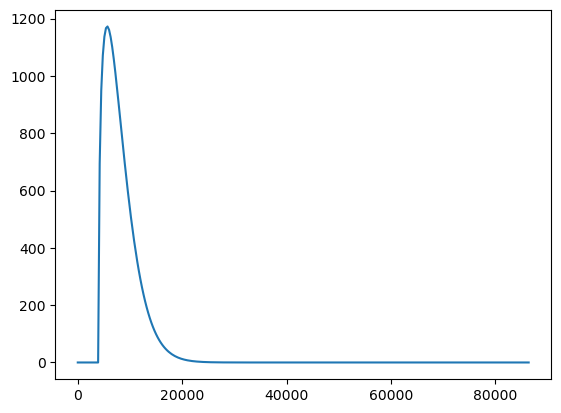

In [14]:
plt.plot(t_eval, sim[:,0])

In [15]:
# Kürzen der simulierten Datensets auf die Zeitschritte, in denen die Reaktion auf Mahlzeiteninputs beobachtet werden kann
mask = sim_data[:,0] <= 20000
sim_data_ukf = sim_data[mask] #Kürzen des Datensatzes für UKF
sim_short = sim[mask] #Kürzen der simulierten Modelldaten auf selbe Länge, wie Datensatz für UKF
sim_short[-1], len(sim_short), len(sim_data_ukf)

(array([13.17661853,  5.20877647,  6.93471663,  5.11463948]), 67, 67)

In [16]:
time_short = t_eval[mask]

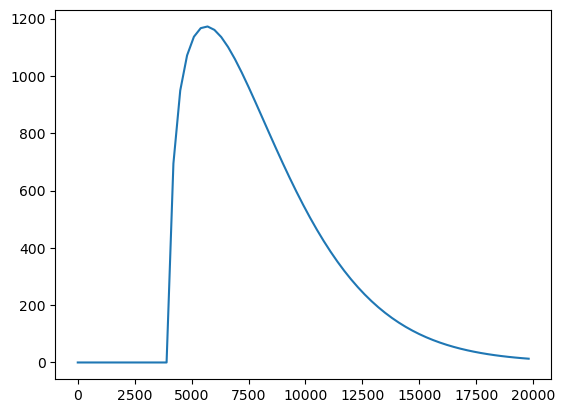

In [17]:
plt.plot(time_short, sim_short[:,0])

In [18]:
#Startwerte für UKF
y_ukf= np.array([0, #M_gut
                G_start, #G_pl
                I_start, #I_pl
                G_start]) #G_i

In [19]:
#Prozessrauschen
#Werte von ChatGPT
Q_ukf = np.diag([
    1e-4,   # M_gut
    5e-4,   # G_pl
    5e-5,   # I_pl
    5e-4,   # G_i
])

In [20]:
#Kovarianzmatrix
# Schätzung von Varianzen mithilfe von Erlandsen-Paper (CV - Werte von Parametern mit ähnlicher Funktionalität) & ChatGPT
# CV = σ / μ
# var = σ^2

var_M_gut = 4 # Empfehlung ChatGPT
var_G_pl = ((0.027+0.077+0.027)/3*param.G_pl_b)**2 # CV-Werte für basale Glukose
var_I_pl = ((0.35+0.72)/2*param.I_pl_b)**2 # CV-Werte für Basales Insulin
var_G_i = var_G_pl*0.9 # Meine Annahme: Etwas kleinere Unsicherheit als Basal-Glukose
var_k1 = 0.5*param.k1**2 # Empfehlung ChatGPT
var_k5 = 0.5*param.k5**2 # Empfehlung ChatGPT
var_tau_g = (0.2*param.tau_g)**2 # Empfehlung ChatGPT

In [21]:
#Kovarianzmatrix
covar_ukf = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i
])

In [22]:
def iterate_euler_Dt(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_sim(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [23]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_ukf = {
    "num_states" : 4,
    "process_noise" : Q_ukf,
    "initial_state" : y_ukf,
    "initial_covar" : covar_ukf,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_Dt
}

In [24]:
estimator_ukf = UKF(**params_ukf)

In [25]:
estimator_ukf.n_dim

4

### Step 300

In [26]:
step = 300
x_pred = np.zeros((len(sim_short), 4))
x_upd = np.zeros((len(sim_short), 4))

In [27]:
for i, row in enumerate(sim_data_ukf):
    t_current = row[0] #simulierte Zeit
    inputs = (t_current, D_mealtime) #D_meal_time[0] = Zeit der Mahlzeit, D_meal_time[1] = Grösse der Mahlzeit in mg
    cgm = row[1] #Simulierte CGM-Daten auslesen
    estimator_ukf.predict(step, inputs) #Modellvorhersage mit UKF
    x_pred[i] = estimator_ukf.get_state() #Vorhersage speichern
    estimator_ukf.update([3], cgm, np.array([[0.2]])) #UKF-Zustand updaten
    x_upd[i] = estimator_ukf.get_state() #Angepasster Zustand speichern

In [28]:
x_pred[-1]

array([4.51669794e+20, 5.12819303e+00, 6.16475926e+00, 5.21132300e+00])

In [29]:
len(x_upd)

67

In [30]:
len(sim_data_ukf)

67

In [31]:
sim_short[-1], len(sim_short)

(array([13.17661853,  5.20877647,  6.93471663,  5.11463948]), 67)

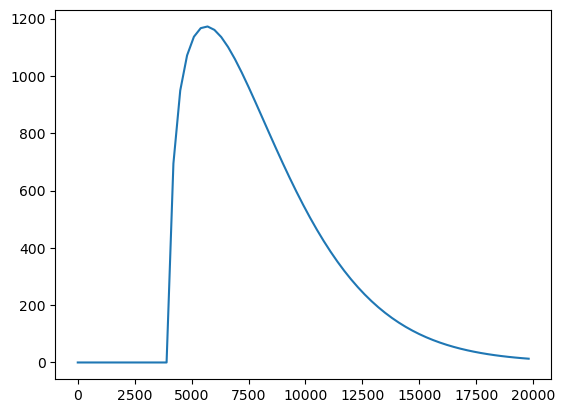

In [32]:
plt.plot(time_short, sim_short[:,0])

In [33]:
t_axis = sim_data_ukf[:,0] #Zeitvektor zum plotten
delta_pred_sim = x_pred-sim_short

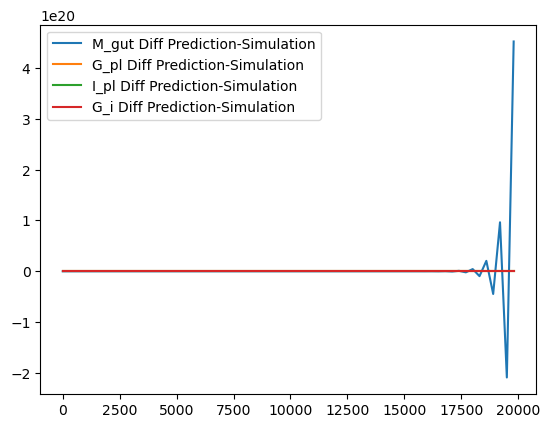

In [34]:
#Überprüfen, wie gross der Unterschied zwischen Simulation und Vorhersage ist
plt.plot(t_axis, delta_pred_sim[:,0], label = "M_gut Diff Prediction-Simulation")
plt.plot(t_axis, delta_pred_sim[:,1], label = "G_pl Diff Prediction-Simulation")
plt.plot(t_axis, delta_pred_sim[:,2], label = "I_pl Diff Prediction-Simulation")
plt.plot(t_axis, delta_pred_sim[:,3], label = "G_i Diff Prediction-Simulation")
plt.legend()

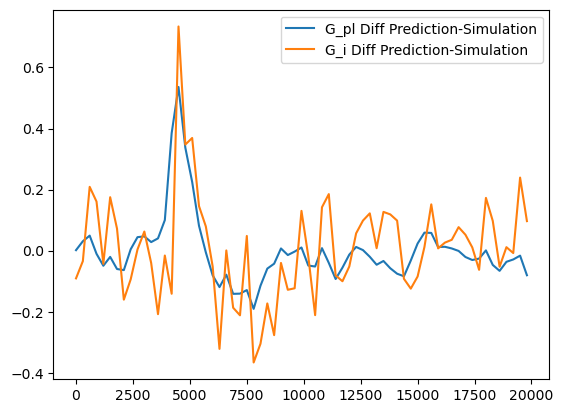

In [35]:
#Differenz Vorhersage zu Simulation nur Glukose-Vorhersagen
plt.plot(t_axis, delta_pred_sim[:,1], label = "G_pl Diff Prediction-Simulation")
plt.plot(t_axis, delta_pred_sim[:,3], label = "G_i Diff Prediction-Simulation")
plt.legend()

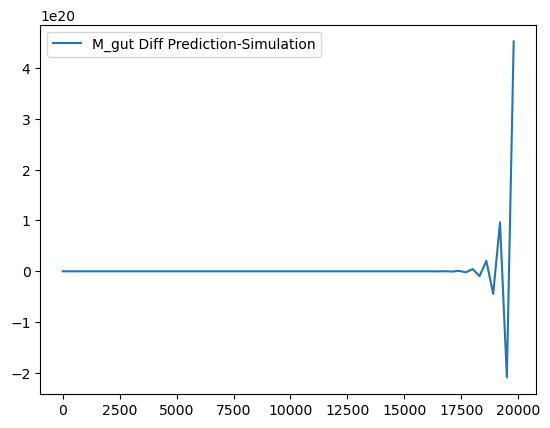

In [36]:
#Differenz Vorhersage zu Simulation nur Magen
plt.plot(t_axis, delta_pred_sim[:,0], label = "M_gut Diff Prediction-Simulation")
plt.legend()

In [37]:
mask_gut = t_axis < 4000
x_pred_masked = x_pred[mask_gut]

In [38]:
t_axis_masked = t_axis[mask_gut]

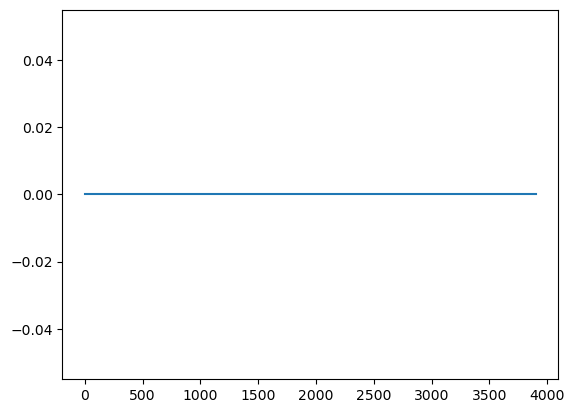

In [39]:
plt.plot(t_axis_masked, x_pred_masked[:,0])

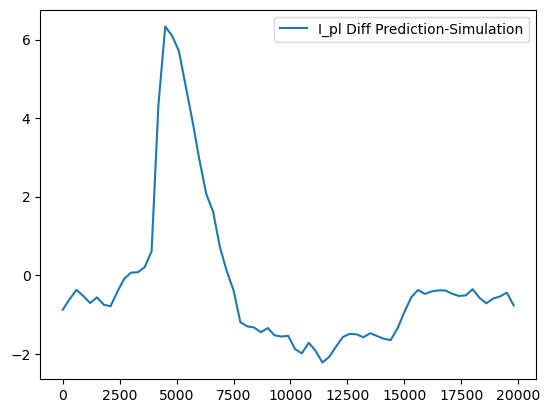

In [40]:
#Differenz Vorhersage zu Simulation nur Insulin
plt.plot(t_axis, delta_pred_sim[:,2], label = "I_pl Diff Prediction-Simulation")
plt.legend()

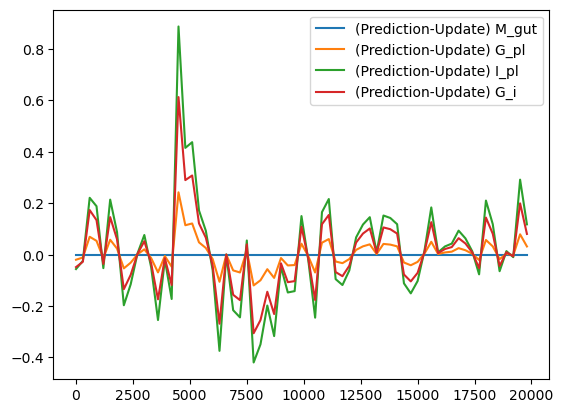

In [41]:
#Überprüfen ob UKF arbeitet
diff = x_pred - x_upd

plt.plot(t_axis, diff[:, 0], label=f"(Prediction-Update) M_gut")
plt.plot(t_axis, diff[:, 1], label=f"(Prediction-Update) G_pl")
plt.plot(t_axis, diff[:, 2], label=f"(Prediction-Update) I_pl")
plt.plot(t_axis, diff[:, 3], label=f"(Prediction-Update) G_i")

plt.legend()
plt.show()

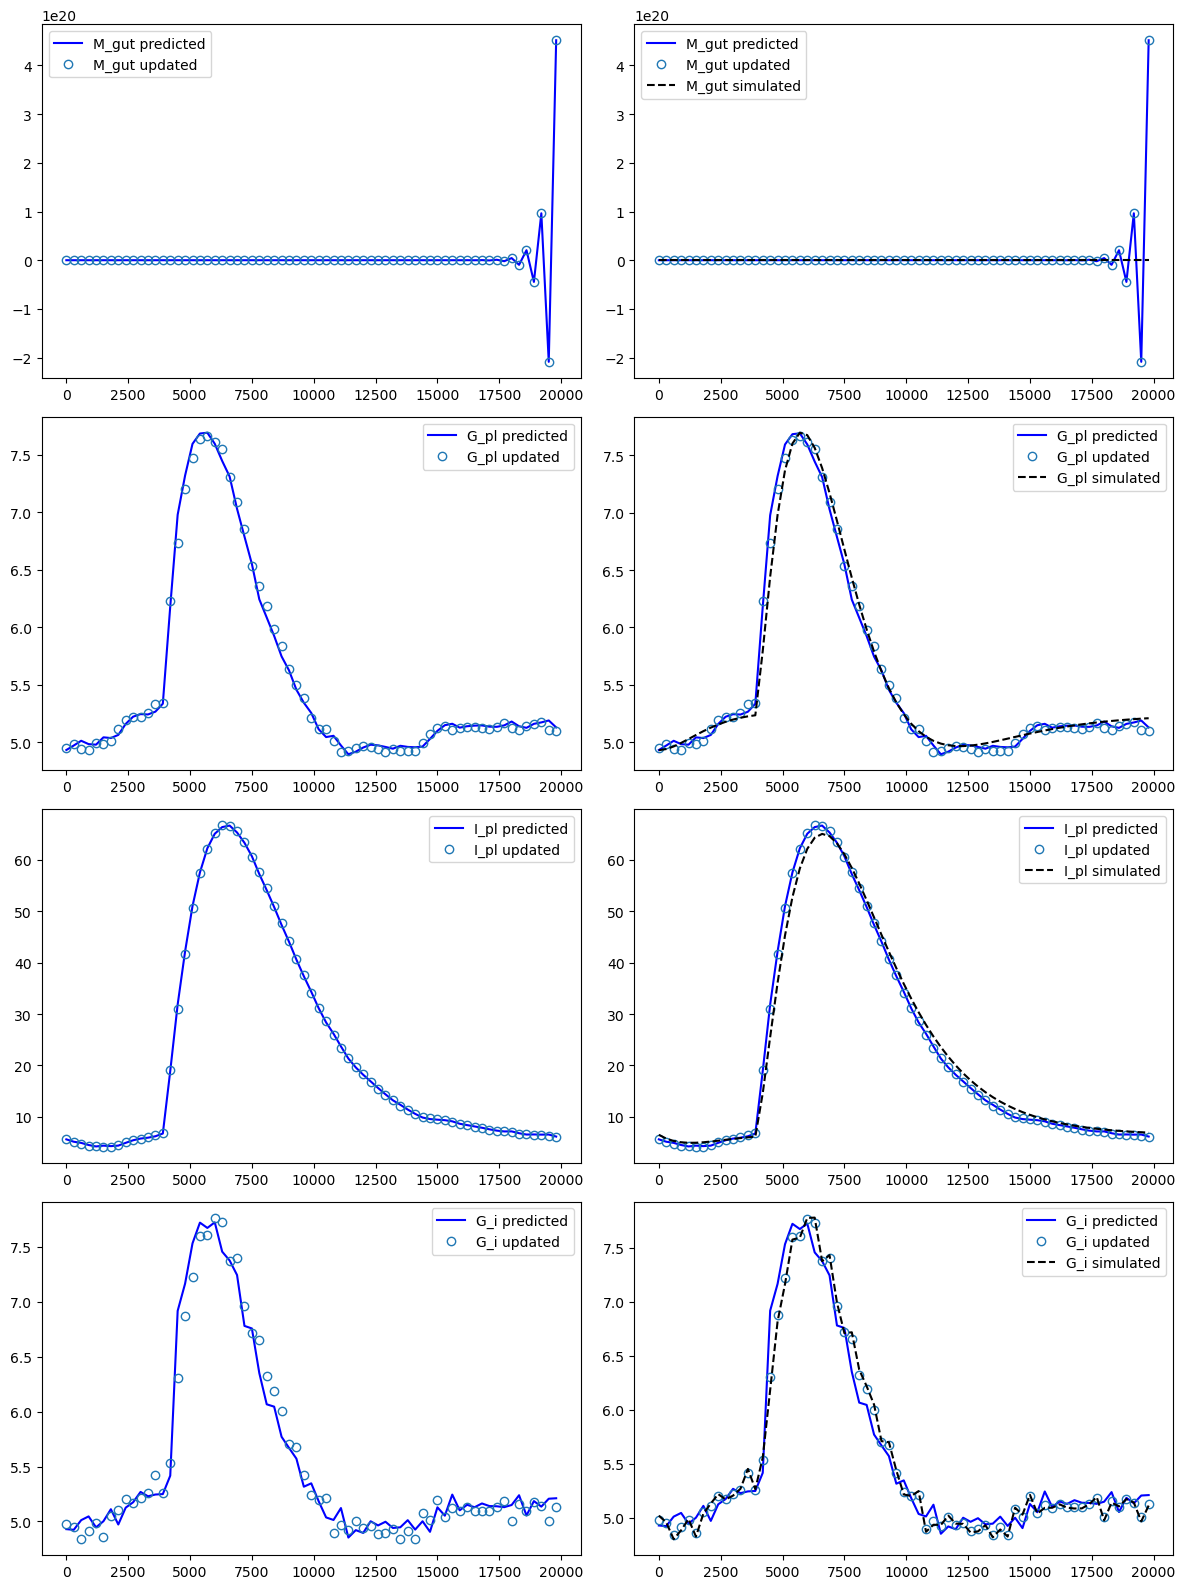

In [42]:
fig, ax = plt.subplots(4,2, figsize = (12, 16))

#UKF Magen/Darm
ax[0,0].plot(t_axis, x_pred[:,0], "b", label = "M_gut predicted")
ax[0,0].plot(t_axis, x_upd[:,0], "o", mfc='none', label = "M_gut updated")
ax[0,0].legend()

#Simulation vs UKF - Magen/Darm
ax[0,1].plot(t_axis, x_pred[:,0], "b", label = "M_gut predicted")
ax[0,1].plot(t_axis, x_upd[:,0], "o", mfc='none', label = "M_gut updated")
ax[0,1].plot(t_axis, sim_short[:,0], "k--", label = "M_gut simulated")
ax[0,1].legend()

#UKF Glukose Blut-Plasma
ax[1,0].plot(t_axis, x_pred[:,1], "b", label = "G_pl predicted")
ax[1,0].plot(t_axis, x_upd[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,0].legend()

#Simulation vs UKF - Glukose im Blut-Plasma
ax[1,1].plot(t_axis, x_pred[:,1], "b", label = "G_pl predicted")
ax[1,1].plot(t_axis, x_upd[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,1].plot(t_axis, sim_short[:,1], "k--", label = "G_pl simulated")
ax[1,1].legend()

#UKF Insulin Blut-Plasma
ax[2,0].plot(t_axis, x_pred[:,2], "b", label = "I_pl predicted")
ax[2,0].plot(t_axis, x_upd[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[2,1].plot(t_axis, x_pred[:,2], "b", label = "I_pl predicted")
ax[2,1].plot(t_axis, x_upd[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,1].plot(t_axis, sim_short[:,2], "k--", label = "I_pl simulated")
ax[2,1].legend()

#UKF Glukose Interstitium
ax[3,0].plot(t_axis, x_pred[:,3], "b", label = "G_i predicted")
ax[3,0].plot(t_axis, x_upd[:,3], "o", mfc='none', label = "G_i updated")
ax[3,0].legend()

#Simulation vs UKF - Glukose im Interstitium
ax[3,1].plot(t_axis, x_pred[:,3], "b", label = "G_i predicted")
ax[3,1].plot(t_axis, x_upd[:,3], "o", mfc='none', label = "G_i updated")
ax[3,1].plot(t_axis, sim_short[:,3], "k--", label = "G_i simulated")
ax[3,1].legend()


plt.tight_layout()

### Variable Schrittgrösse

In [43]:
estimator_ss = UKF(**params_ukf)

In [44]:
step_ss = 30
x_pred_ss = np.zeros((int(24*3600/step_ss)+1, 4))
x_upd_ss = np.zeros((len(sim), 4))

In [45]:
len(x_pred_ss), len(x_upd_ss), len(sim)

(2881, 289, 289)

In [46]:
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred_ss)):
    inputs = (t_current, D_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_ss.predict(step_ss, inputs) #Modellvorhersage
    x_pred_ss[i] = estimator_ss.get_state() #Zustand speichern
    
    if t_current == sim_data[data_count,0]:
        cgm = sim_data[data_count, 1] #CGM-Daten auslesen
        estimator_ss.update([3], cgm, R)
        x_upd_ss[data_count] = estimator_ss.get_state()
        data_count += 1

    
    t_current += step_ss

In [47]:
np.shape(x_pred_ss[:,3]), np.shape(sim)

((2881,), (289, 4))

In [48]:
time_ss = np.arange(float(1),float((24*3600)+2), float(step_ss))
np.shape(time_ss), time_ss[-1]

((2881,), 86401.0)

In [49]:
sim[-1], x_pred_ss[-1]

(array([-5.57907605e-11,  5.24000000e+00,  6.50000000e+00,  5.33502747e+00]),
 array([-4.56575353e-17,  5.27712104e+00,  6.71498037e+00,  5.27925285e+00]))

In [50]:
len(t_eval)

289

In [51]:
mask_compare = np.isin(time_ss, t_eval)

In [52]:
time_compare = time_ss[mask_compare]

In [53]:
x_pred_compare = x_pred_ss[mask_compare]

In [54]:
compare_pred_sim = x_pred_compare - sim

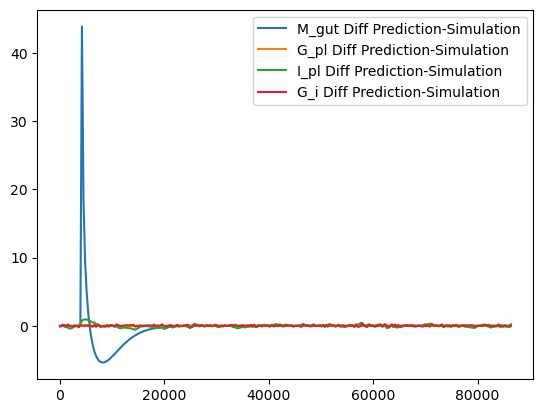

In [55]:
#Überprüfen, wie gross der Unterschied zwischen Simulation und Vorhersage ist
plt.plot(time_compare, compare_pred_sim[:,0], label = "M_gut Diff Prediction-Simulation")
plt.plot(time_compare, compare_pred_sim[:,1], label = "G_pl Diff Prediction-Simulation")
plt.plot(time_compare, compare_pred_sim[:,2], label = "I_pl Diff Prediction-Simulation")
plt.plot(time_compare, compare_pred_sim[:,3], label = "G_i Diff Prediction-Simulation")
plt.legend()

In [56]:
compare_pred_upd = x_pred_compare - x_upd_ss

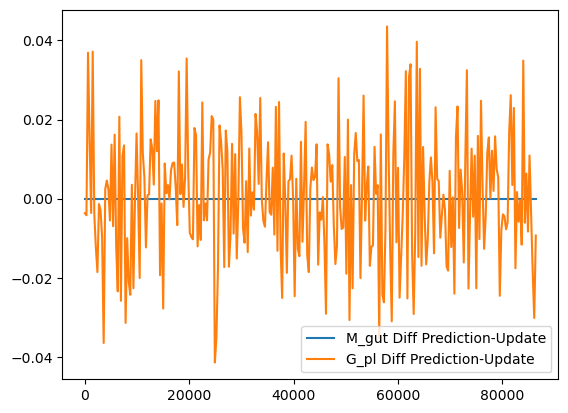

In [57]:
#Überprüfen, ob UKF arbeitet
plt.plot(time_compare, compare_pred_upd[:,0], label = "M_gut Diff Prediction-Update")
plt.plot(time_compare, compare_pred_upd[:,1], label = "G_pl Diff Prediction-Update")
plt.legend()

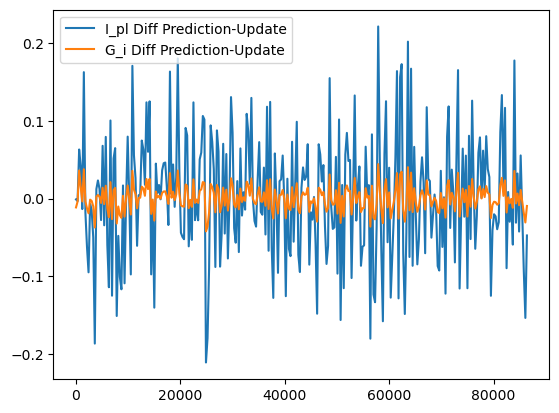

In [58]:
plt.plot(time_compare, compare_pred_upd[:,2], label = "I_pl Diff Prediction-Update")
plt.plot(time_compare, compare_pred_upd[:,3], label = "G_i Diff Prediction-Update")
plt.legend()

In [59]:
RSS = np.zeros(compare_pred_sim.shape[1])
for col in range(compare_pred_sim.shape[1]):
    RSS[col] = np.sum(compare_pred_sim[:,col]**2)

RMSE = np.sqrt(1/len(compare_pred_sim)*RSS)

MAE = np.zeros(compare_pred_sim.shape[1])
for col in range(compare_pred_sim.shape[1]):
    MAE[col] = np.mean(np.absolute(compare_pred_sim[:,col]))

bias = np.zeros(compare_pred_sim.shape[1])
for col in range(compare_pred_sim.shape[1]):
    bias[col] = np.sum(compare_pred_sim[:,col])/len(compare_pred_sim)

RSS, RMSE, MAE, bias

(array([2.82428157e+03, 1.21841521e-01, 1.34924745e+01, 2.61198818e+00]),
 array([3.12611589, 0.02053283, 0.2160712 , 0.09506851]),
 array([0.67798551, 0.01562629, 0.15361062, 0.07679207]),
 array([-0.13309728, -0.00213281, -0.02937838,  0.00205276]))

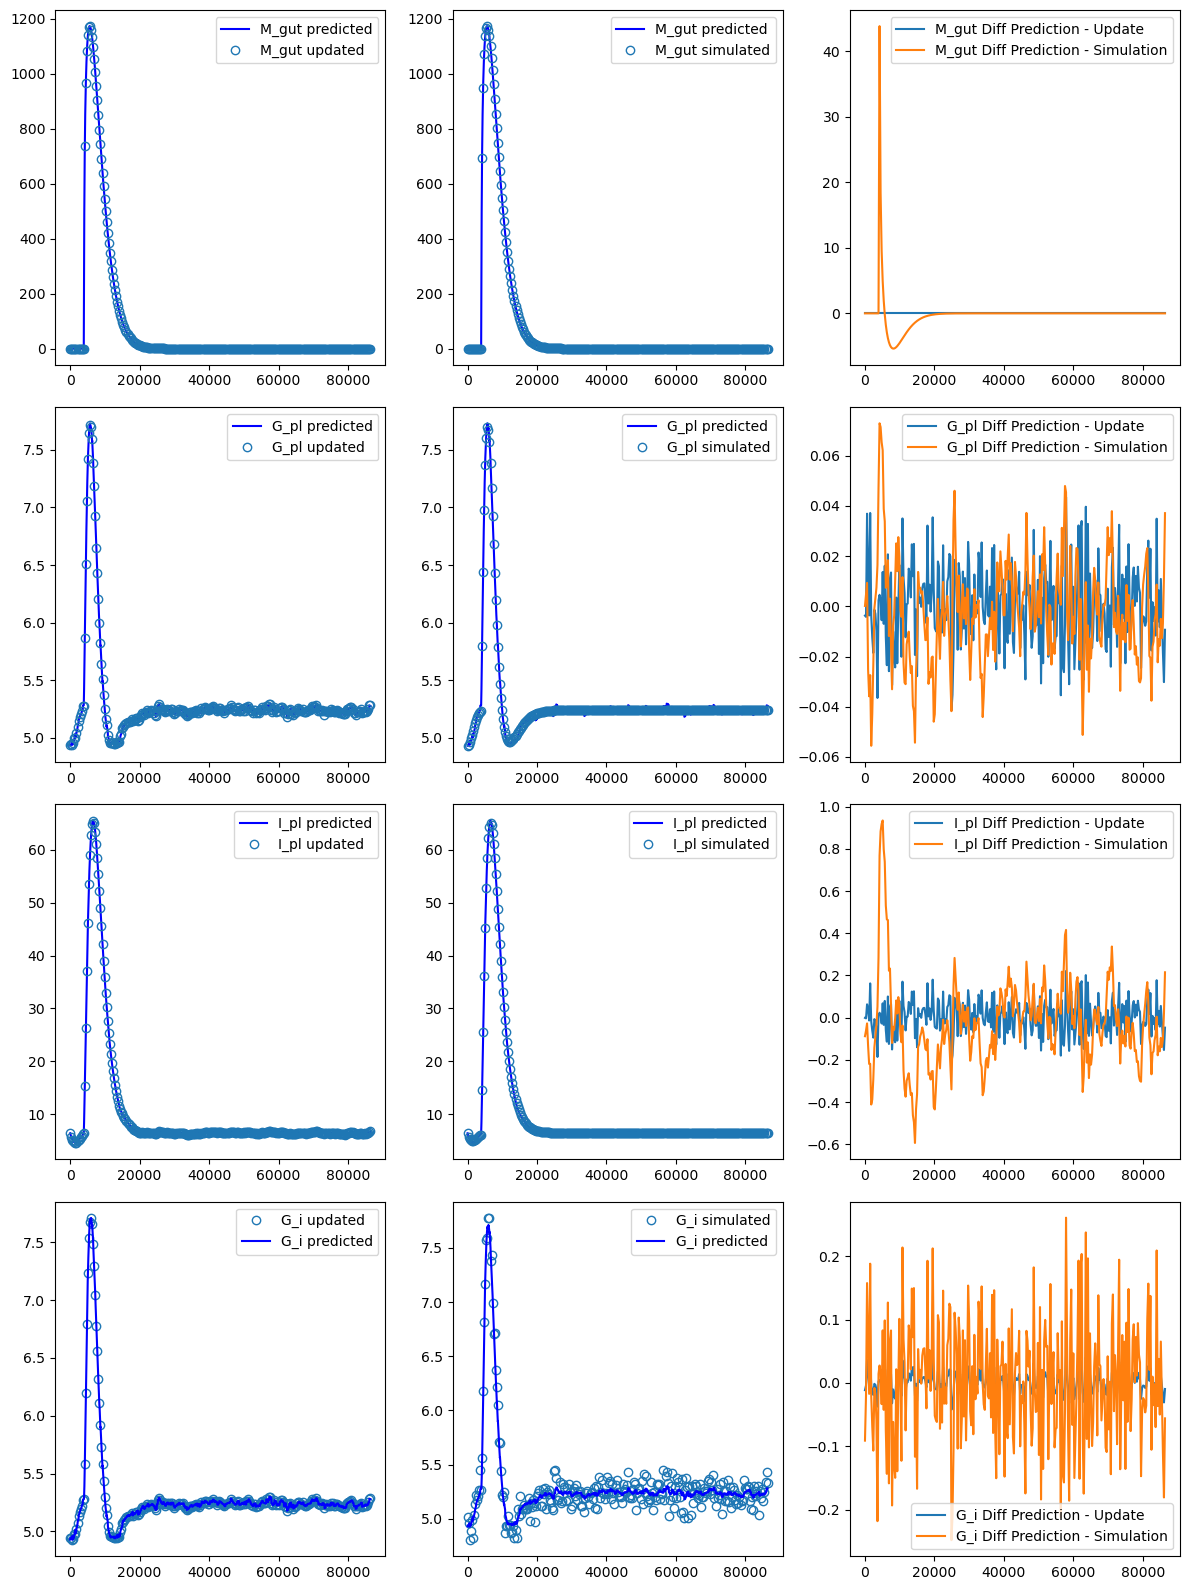

In [60]:
fig, ax = plt.subplots(4,3, figsize = (12, 16))

#UKF Magen/Darm
ax[0,0].plot(time_ss, x_pred_ss[:,0], "b", label = "M_gut predicted")
ax[0,0].plot(time_compare, x_upd_ss[:,0], "o", mfc='none', label = "M_gut updated")
ax[0,0].legend()


#Simulation vs UKF - Magen/Darm
ax[0,1].plot(time_ss, x_pred_ss[:,0], "b", label = "M_gut predicted")
ax[0,1].plot(time_compare, sim[:,0], "o",  mfc='none',label = "M_gut simulated")
ax[0,1].legend()

#Differenz M_gut Prediction-Update und Prediction-Simulation
ax[0,2].plot(time_compare, compare_pred_upd[:,0], label = "M_gut Diff Prediction - Update")
ax[0,2].plot(time_compare, compare_pred_sim[:,0], label = "M_gut Diff Prediction - Simulation")
ax[0,2].legend()


#UKF Glukose Blut-Plasma
ax[1,0].plot(time_ss, x_pred_ss[:,1], "b", label = "G_pl predicted")
ax[1,0].plot(time_compare, x_upd_ss[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,0].legend()

#Simulation vs UKF - Glukose im Blut-Plasma
ax[1,1].plot(time_ss, x_pred_ss[:,1], "b", label = "G_pl predicted")
ax[1,1].plot(time_compare, sim[:,1], "o", mfc='none', label = "G_pl simulated")
ax[1,1].legend()

#Glukose Blutplasma: Differenz Prediction-Update und Prediction-Simulation
ax[1,2].plot(time_compare, compare_pred_upd[:,1], label = "G_pl Diff Prediction - Update")
ax[1,2].plot(time_compare, compare_pred_sim[:,1], label = "G_pl Diff Prediction - Simulation")
ax[1,2].legend()


#UKF Insulin Blut-Plasma
ax[2,0].plot(time_ss, x_pred_ss[:,2], "b", label = "I_pl predicted")
ax[2,0].plot(time_compare, x_upd_ss[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,0].legend()


#Simulation vs UKF - Insulin im Blut-Plasma
ax[2,1].plot(time_ss, x_pred_ss[:,2], "b", label = "I_pl predicted")
ax[2,1].plot(time_compare, sim[:,2], "o",  mfc='none', label = "I_pl simulated")
ax[2,1].legend()

#Insulin Blutplasma: Differenz Prediction-Update und Prediction-Simulation
ax[2,2].plot(time_compare, compare_pred_upd[:,2], label = "I_pl Diff Prediction - Update")
ax[2,2].plot(time_compare, compare_pred_sim[:,2], label = "I_pl Diff Prediction - Simulation")
ax[2,2].legend()


#UKF Glukose Interstitium
ax[3,0].plot(time_compare, x_upd_ss[:,3], "o", mfc='none', label = "G_i updated")
ax[3,0].plot(time_ss, x_pred_ss[:,3], "b", label = "G_i predicted")
ax[3,0].legend()

#Simulation vs UKF - Glukose im Interstitium
ax[3,1].plot(time_compare, sim[:,3], "o",  mfc='none', label = "G_i simulated")
ax[3,1].plot(time_ss, x_pred_ss[:,3], "b", label = "G_i predicted")
ax[3,1].legend()

#Glukose Interstitium: Differenz Prediction-Update und Prediction-Simulation
ax[3,2].plot(time_compare, compare_pred_upd[:,3], label = "G_i Diff Prediction - Update")
ax[3,2].plot(time_compare, compare_pred_sim[:,3], label = "G_i Diff Prediction - Simulation")
ax[3,2].legend()

plt.tight_layout()

## B) Schätzung: 4 Modellzustände, leicht angepasste Parameter

In [61]:
from Test_UKF_ode_Dt_erw import f_odes_Dt_erw

In [62]:
# Erzeugen eines Datensets mit verzögertem Mahlzeiteninput für simulierte Daten
D_in = np.zeros(len(t_eval))
D_in[13] = D #einfügen Mahlzeiteninput
D_in[61] = D #einfügen Mahlzeiteninput
D_in_mealtime = np.column_stack((t_eval, D_in)) #Array mit Zeitpunkten & Mahlzeiteninputs

In [63]:
delta_k1 = np.absolute(param.k1*0.9-param.k1)
delta_k5 = np.absolute(param.k5*1.2-param.k5)
delta_tau_g = np.absolute(param.tau_g*1.2-param.tau_g)

In [64]:
k1_sim = param.k1+delta_k1
k5_sim = param.k5+delta_k5
tau_g_sim = param.tau_g+delta_tau_g

k1_sim, k5_sim, tau_g_sim

(0.0002475, 7.599999999999999e-05, 180.0)

In [65]:
#Array mit Startzuständen der Simulation

y_in = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            delta_k1, #Differenz zum Literaturwert k1
            delta_k5, #Differenz zum Literaturwert k5
            delta_tau_g]) #Differenz zum Literaturwert tau_g 

In [66]:
sim_b = f_solve_Dt(f_odes_Dt_erw, y_in, D_in_mealtime)

In [67]:
sim_b[:,3]+=noise2

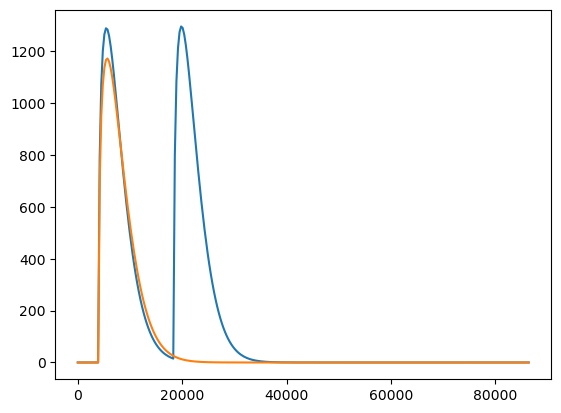

In [68]:
plt.plot(t_eval, sim_b[:,0], label = "M_gut") #Simulierte Magen-Kurve
plt.plot(t_eval, sim[:,0], label = "M_gut Literatur") #Simulierte Magen_Kurve mit Literatur-Werten

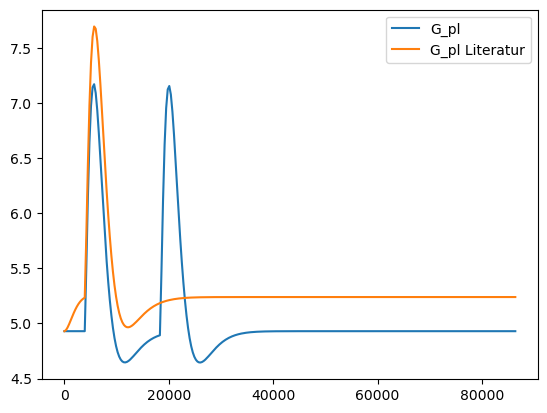

In [69]:
plt.plot(t_eval, sim_b[:,1], label = "G_pl") #Simulierte Plasma-Glukose
plt.plot(t_eval, sim[:,1], label = "G_pl Literatur") #Plasma-Glukose mit Literaturwerten
plt.legend()

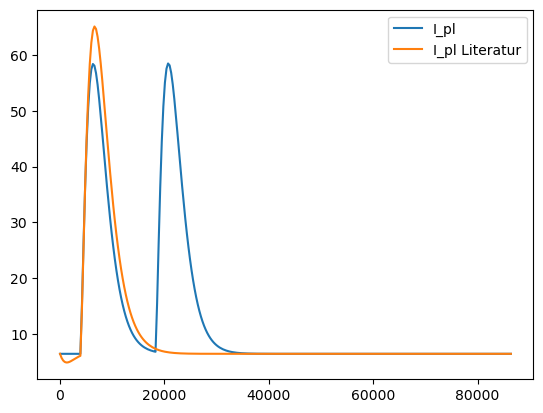

In [70]:
plt.plot(t_eval, sim_b[:,2], label = "I_pl") #Simuliertes Insulin
plt.plot(t_eval, sim[:,2], label = "I_pl Literatur") #Plasma-Insulin mit Literaturwerten
plt.legend()

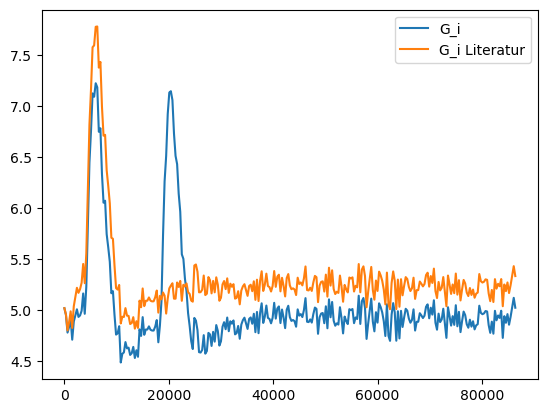

In [71]:
plt.plot(t_eval, sim_b[:,3], label = "G_i") #Simuliertes Insulin
plt.plot(t_eval, sim[:,3], label = "G_i Literatur") #Plasma-Insulin mit Literaturwerten
plt.legend()

#### UKF: Schätzung der veränderten Simulation, nur Zustände, keine Parameter

In [72]:
from Test_UKF_ode_Dt_par import f_odes_Dt_par #Erlaubt Übergabe von verändertem k1, k5, tau_g ohne Schätzung der Parameter

In [73]:
#Schätzfehler
from estimate_error import estimate_error
from mask_data import mask_data

In [74]:
#Datensatz für UKF vorbereiten: 
# data_set_b[0]: Zeit in s, data_set_b[1]: simulierte CGM-Daten, data_set_b[2]: Mahlzeiteninputs

data_set_b = np.column_stack((t_eval, sim_b[:,3], D_in)) #Datensatz 1

In [75]:
#Parameter verändern
k1_adj = param.k1+delta_k1
k5_adj = param.k5+delta_k5
tau_g_adj = param.tau_g+delta_tau_g

In [76]:
def iterate_euler_4s(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    par = np.array((k1_adj, k5_adj, tau_g_adj))
    dydt = f_odes_Dt_par(y_in, t_current, D_meal, par)
    y_next = y_in + dydt*delta_t
    return y_next

In [77]:
#Prozessrauschen
Q_4s = np.diag([
    1e-4,   # M_gut
    5e-4,   # G_pl
    5e-5,   # I_pl
    5e-4   # G_i
])

In [78]:
#Kovarianz-Matrix
covar_4s = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i #G_i 
])

In [79]:
#Startwerte
y_4s = np.array([0, #M_gut
                G_start, #G_pl
                I_start, #I_pl
                G_start #G_i
               ]) 

In [80]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4s = {
    "num_states" : 4,
    "process_noise" : Q_4s,
    "initial_state" : y_4s,
    "initial_covar" : covar_4s,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_4s
}

In [81]:
#UKF für 4 Zustände ohne Parameterschätzung
estimator_4s = UKF(**params_4s)

In [82]:
#Schrittgrösse
step_4s = 60
x_pred_4s = np.zeros((int(24*3600/step_4s + 1),4))
x_upd_4s = np.zeros((len(data_set_b),4))
time_4s = np.arange(1, 24*3600+2, step_4s)

In [83]:
#Schätzen der 4 Zustände bei von der Literatur abweichenden Parametern
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred_4s)):
    inputs = (t_current, D_in_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_4s.predict(step_4s, inputs) #Modellvorhersage
    x_pred_4s[i] = estimator_4s.get_state() #Zustand speichern
    
    if t_current == data_set_b[data_count,0]:
        cgm = data_set_b[data_count, 1] #CGM-Daten auslesen
        estimator_4s.update([3], cgm, R)
        x_upd_4s[data_count] = estimator_4s.get_state()
        data_count += 1

    t_current += step_4s

In [84]:
x_pred_4s_masked = mask_data(time_4s, t_eval, x_pred_4s)

In [85]:
comp_4s_pred_sim = x_pred_4s_masked - sim_b[:, 0:4]

In [86]:
comp_4s_pred_upd = x_pred_4s_masked - x_upd_4s

array([[ 2.65773448e+04,  2.53340758e-01,  3.01588004e+01,
         2.76296587e+00],
       [ 9.58974092e+00,  2.96076277e-02,  3.23041345e-01,
         9.77774796e-02],
       [ 2.90547391e+00,  2.27685353e-02,  2.15968393e-01,
         7.92431070e-02],
       [-6.56895871e-01, -2.68236732e-03, -3.53001955e-02,
         1.48340433e-03]])

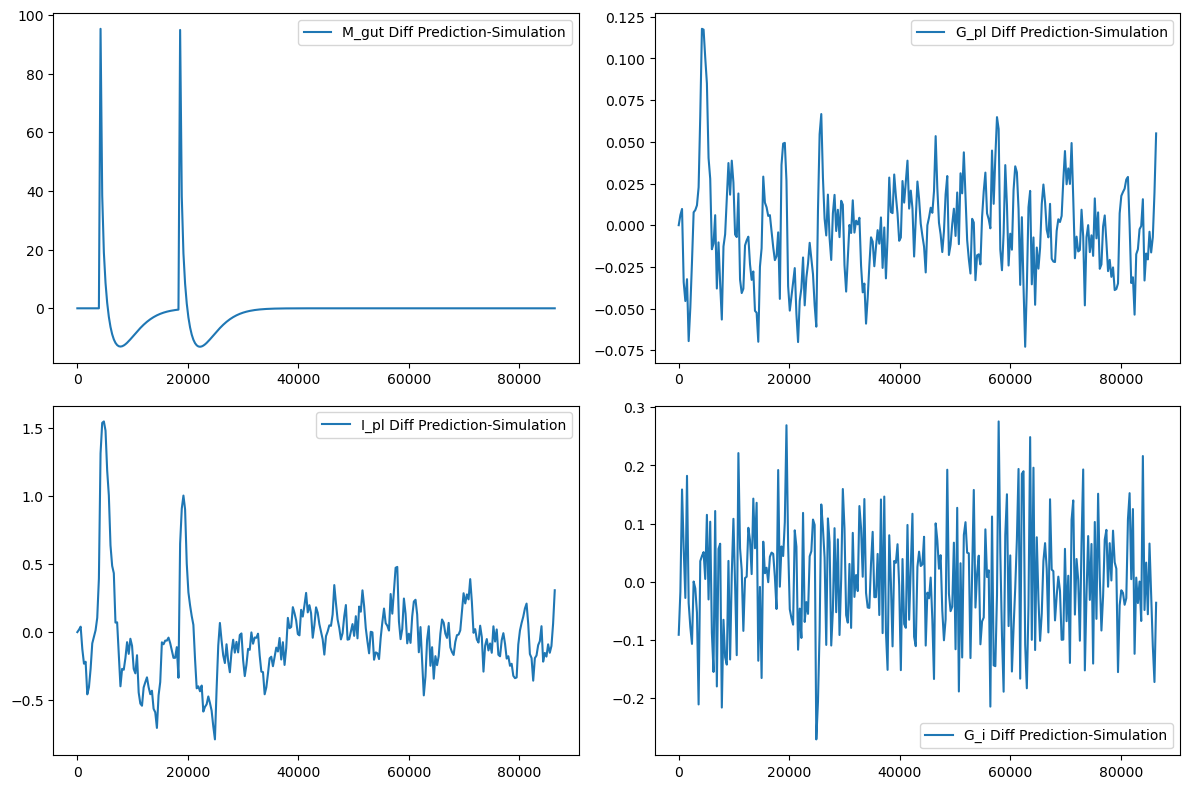

In [87]:
estimate_error(comp_4s_pred_sim, t_eval)

In [88]:
from plot_ukf import plot_ukf

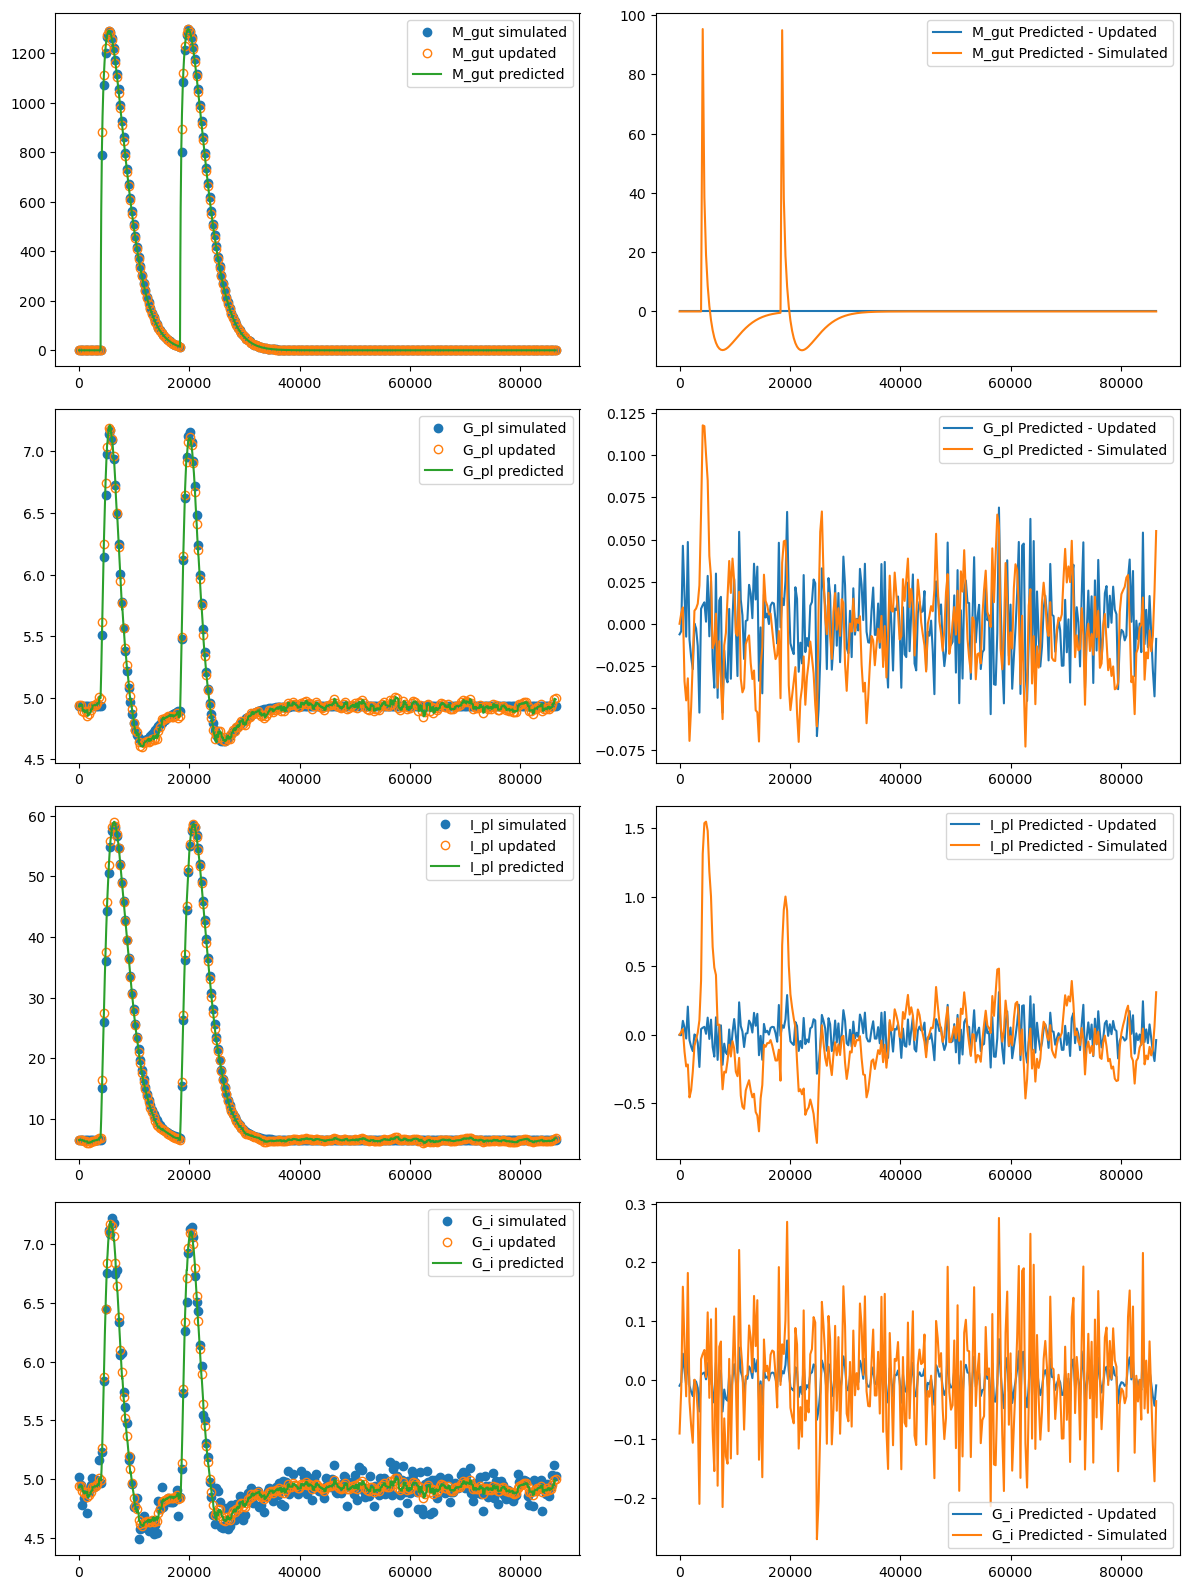

In [89]:
plot_ukf(sim_b[:,0:4], x_upd_4s, x_pred_4s, t_eval, time_4s)

#### UKF: Erweiterte Schätzung: Zustände & Parameter --> Parameter möglichst konstant halten

In [90]:
#Prozessrauschen
Q_4s_3p = np.diag([
    1e-4,   # M_gut
    5e-4,   # G_pl
    5e-5,   # I_pl
    5e-4,   # G_i
    0, # k1 --> keine Zustandsschätzung
    0, # k5 --> keine Zustandsschätzung
    0 # tau_g --> keine Zustandsschätzung
])

In [91]:
#Kovarianz-Matrix
covar_4s_3p = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
    0, # k1 --> keine Unsicherheit
    0, # k5 --> keine Unsicherheit
    0 #tau_g --> keine Unsicherheit
])

In [92]:
#Startwerte
y_4s_3p = np.array([0, #M_gut
                G_start, #G_pl
                I_start, #I_pl
                G_start, #G_i
                delta_k1, #Differenz zum Literaturwert von k1
                delta_k5, #Differenz zum Literaturwert von k5
                delta_tau_g #Differenz zum Literaturwert von tau_g
               ]) 

In [93]:
def iterate_euler_4s_3p(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_erw(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [94]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4s_3p = {
    "num_states" : 7,
    "process_noise" : Q_4s_3p,
    "initial_state" : y_4s_3p,
    "initial_covar" : covar_4s_3p,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_4s_3p
}

In [95]:
#UKF für 4 Zustände, 3 Parameter
estimator_4s_3p = UKF(**params_4s_3p)

In [96]:
#Schrittgrösse
step_b = 60
x_pred_b = np.zeros((int(24*3600/step_b + 1),7))
x_upd_b = np.zeros((len(data_set_b),7))
time_b = np.arange(1, 24*3600+2, step_b)

In [97]:
len(x_pred_b), len(x_upd_b), len(time_b)

(1441, 289, 1441)

In [98]:
#Schätzen der 4 Zustände bei veränderten Parametern
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred_b)):
    inputs = (t_current, D_in_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_4s_3p.predict(step_b, inputs) #Modellvorhersage
    x_pred_b[i] = estimator_4s_3p.get_state() #Zustand speichern
    
    if t_current == data_set_b[data_count,0]:
        cgm = data_set_b[data_count, 1] #CGM-Daten auslesen
        estimator_4s_3p.update([3], cgm, R)
        x_upd_b[data_count] = estimator_4s_3p.get_state()
        data_count += 1

    t_current += step_b

/home/jovyan/work/examples/Test_UKF_pyUKF.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[i+1] = self.x + spr_mat[i]
/home/jovyan/work/examples/Test_UKF_pyUKF.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[i+1+self.n_dim] = self.x - spr_mat[i]


In [99]:
x_pred_b_masked = mask_data(time_b, t_eval, x_pred_b)

In [100]:
#Differenz Prediction - Simulation und Prediction - Update
comp_b_pred_sim = x_pred_b_masked-sim_b
comp_b_pred_upd = x_pred_b_masked-x_upd_b

In [101]:
comp_b_pred_sim[-1]

array([ 1.72555855e-11,  5.50596254e-02,  3.07870923e-01, -3.58730575e-02,
       -5.29317963e-13, -3.14643033e-13, -6.98957592e-07])

(0.00022499999947068203, 0.00022499999999248685)

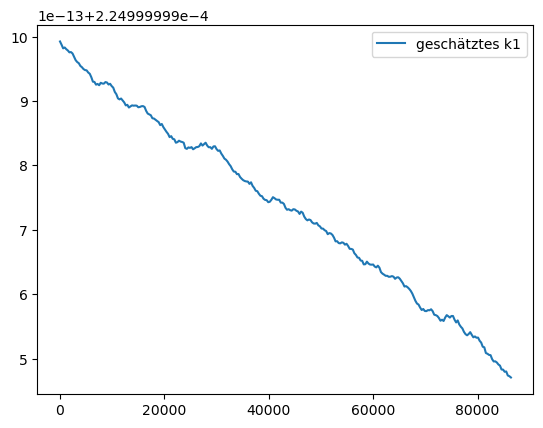

In [102]:
k1_est = param.k1+comp_b_pred_sim[:,4]
k5_est = param.k5+comp_b_pred_sim[:,5]
tau_g_est = param.tau_g+comp_b_pred_sim[:,6]

plt.plot(t_eval, k1_est, label = "geschätztes k1")
plt.legend()
k1_est[-1], k1_est[0]

(6.33333330186903e-05, 6.333333332999684e-05)

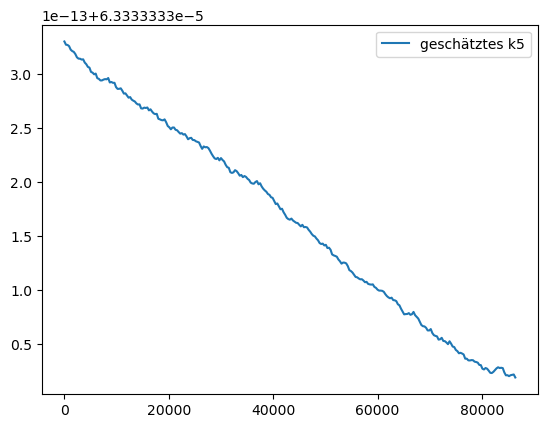

In [103]:
plt.plot(t_eval, k5_est, label = "geschätztes k5")
plt.legend()
k5_est[-1], k5_est[0]

(149.9999993010424, 150.0000000046566)

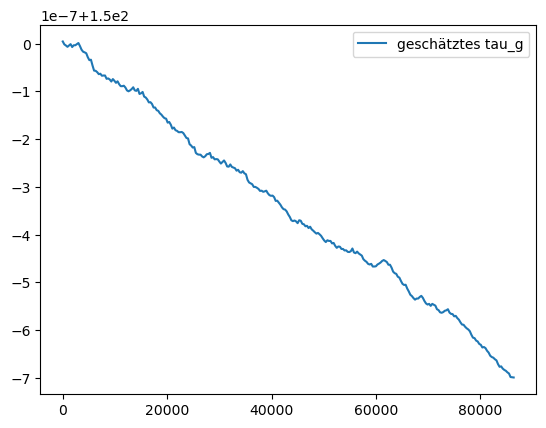

In [104]:
plt.plot(t_eval, tau_g_est, label = "geschätztes tau_g")
plt.legend()
tau_g_est[-1], tau_g_est[0]

array([[ 2.65773444e+04,  2.53340759e-01,  3.01587997e+01,
         2.76296587e+00,  2.61251751e-23,  1.05670760e-23,
         4.47187667e-11],
       [ 9.58974085e+00,  2.96076278e-02,  3.23041342e-01,
         9.77774797e-02,  3.00663483e-13,  1.91217878e-13,
         3.93365246e-07],
       [ 2.90547386e+00,  2.27685352e-02,  2.15968391e-01,
         7.92431070e-02,  2.65571230e-13,  1.66978376e-13,
         3.40988131e-07],
       [-6.56895868e-01, -2.68236816e-03, -3.53001953e-02,
         1.48340328e-03, -2.65571230e-13, -1.66978376e-13,
        -3.40946238e-07]])

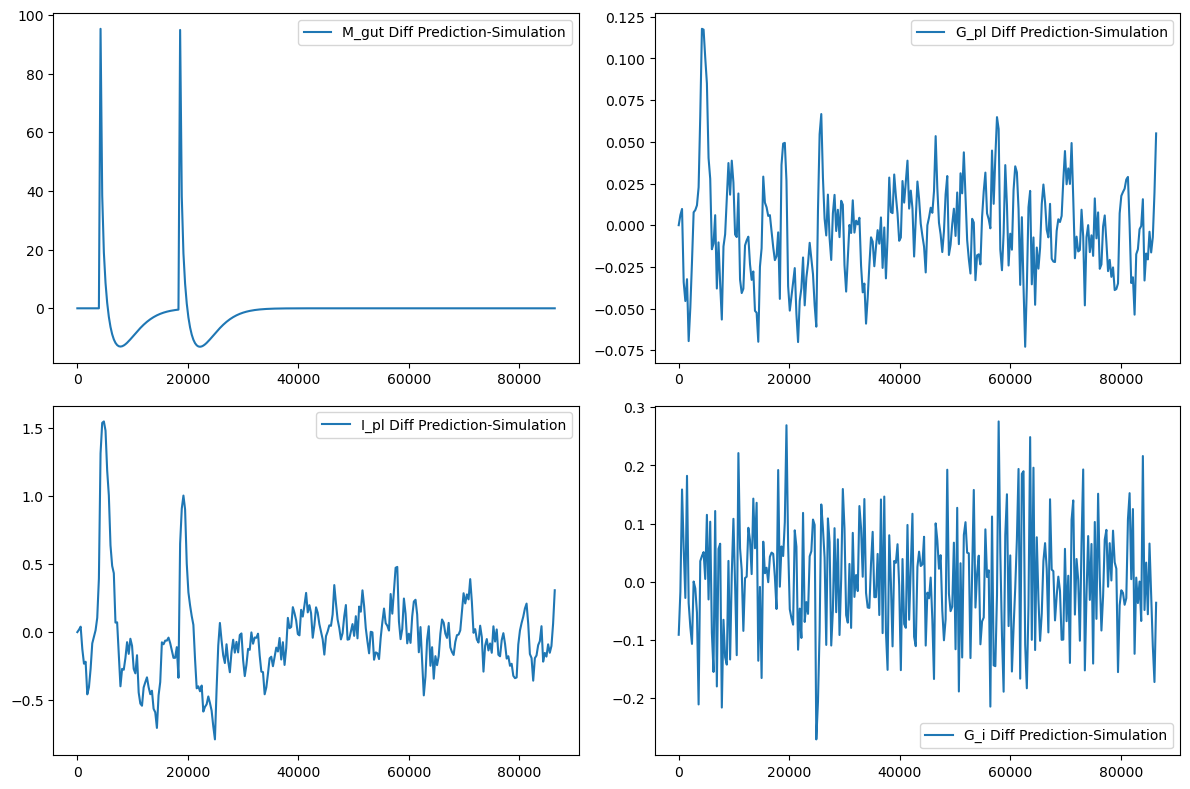

In [105]:
estimate_error(comp_b_pred_sim, t_eval)

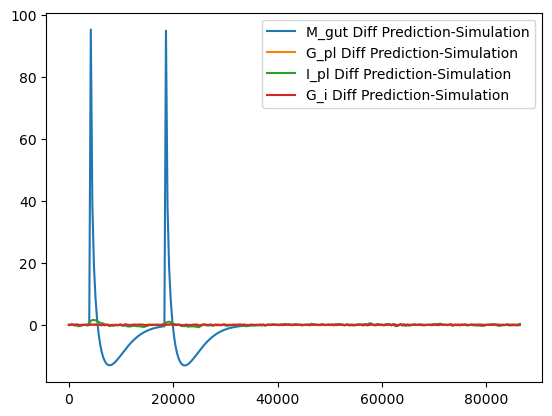

In [106]:
#Überprüfen, wie gross der Unterschied zwischen Simulation und Vorhersage ist
plt.plot(t_eval, comp_b_pred_sim[:,0], label = "M_gut Diff Prediction-Simulation")
plt.plot(t_eval, comp_b_pred_sim[:,1], label = "G_pl Diff Prediction-Simulation")
plt.plot(t_eval, comp_b_pred_sim[:,2], label = "I_pl Diff Prediction-Simulation")
plt.plot(t_eval, comp_b_pred_sim[:,3], label = "G_i Diff Prediction-Simulation")
plt.legend()

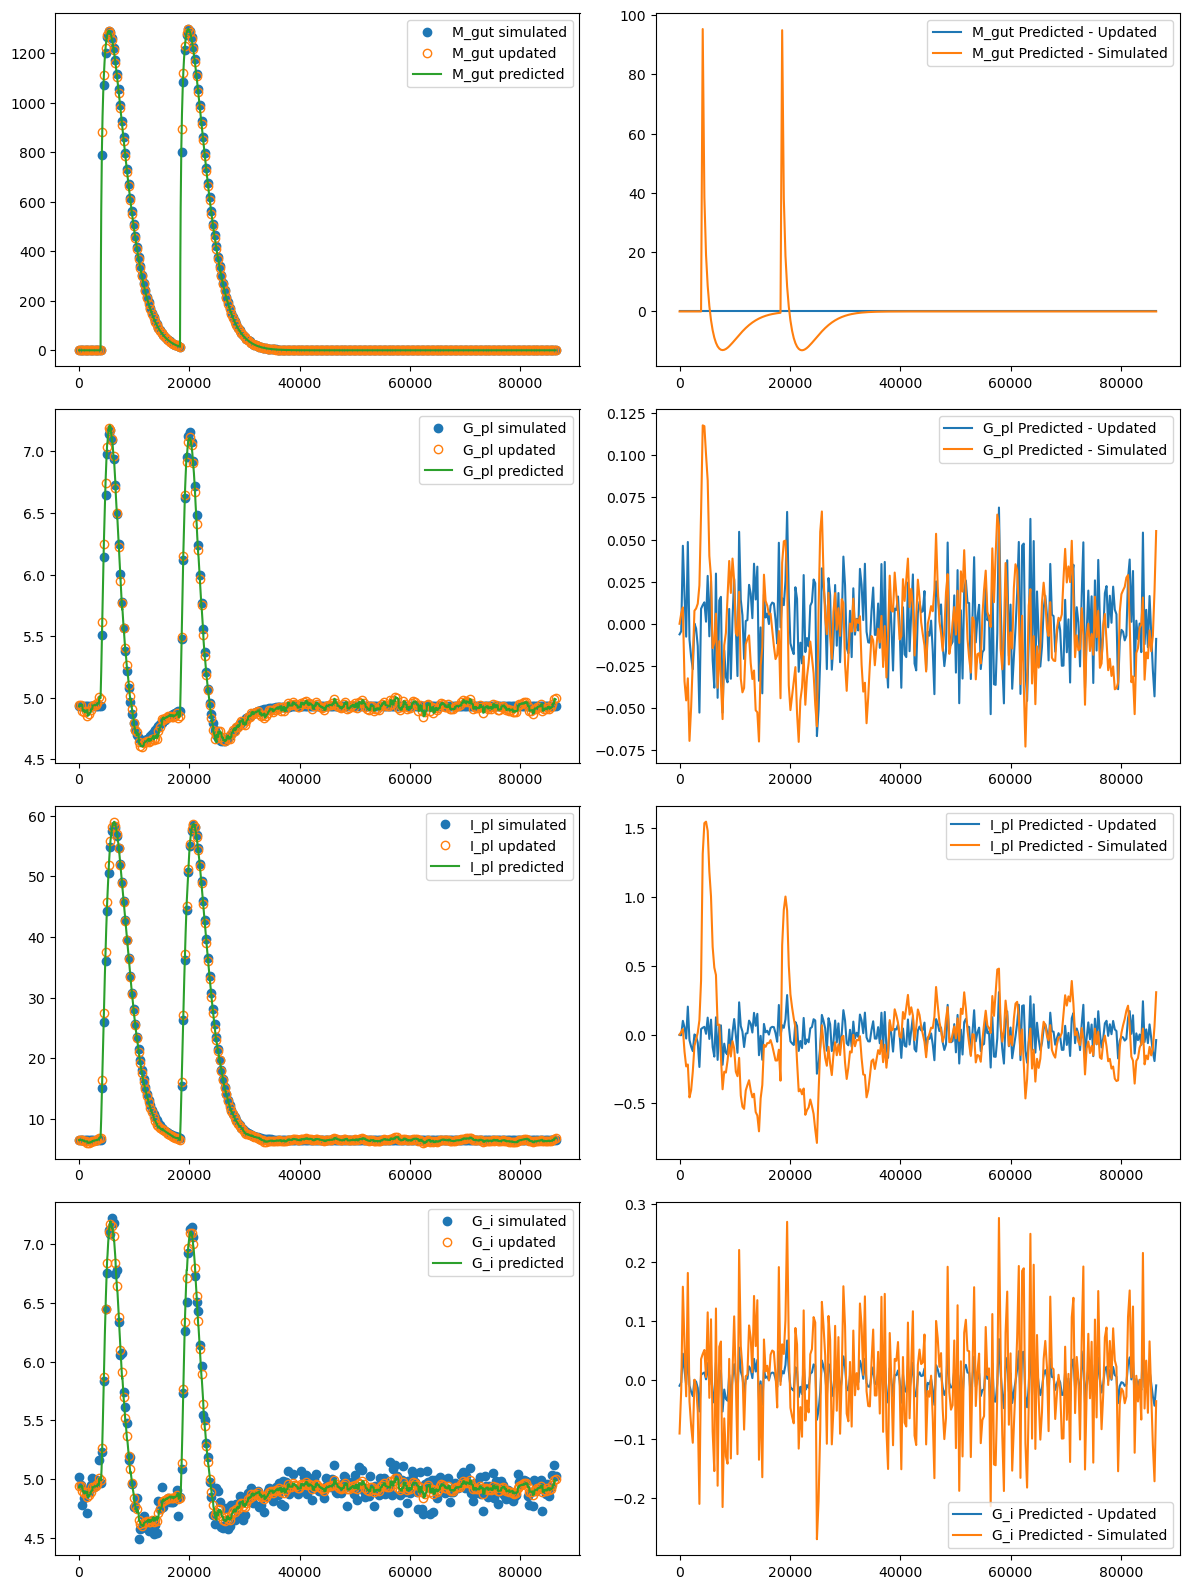

In [107]:
fig, ax = plt.subplots(4,2, figsize = (12, 16))

#Magen/Darm: Predicted - Updated - simuliert
ax[0,0].plot(t_eval, sim_b[:,0], "o", label = "M_gut simulated")
ax[0,0].plot(t_eval, x_upd_b[:,0], "o", mfc="none", label = "M_gut updated")
ax[0,0].plot(time_b, x_pred_b[:,0], label = "M_gut predicted")
ax[0,0].legend()


#Magen/Darm: Differenz Predicted - updated - simuliert
ax[0,1].plot(t_eval, comp_b_pred_upd[:,0], label = "M_gut Predicted - Updated")
ax[0,1].plot(t_eval, comp_b_pred_sim[:,0], label = "M_gut Predicted - Simulated")
ax[0,1].legend()


#Glukose Blut-Plasma: Predicted - Updated - simuliert
ax[1,0].plot(t_eval, sim_b[:,1], "o",  label = "G_pl simulated")
ax[1,0].plot(t_eval, x_upd_b[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,0].plot(time_b, x_pred_b[:,1], label = "G_pl predicted")
ax[1,0].legend()


#Glukose im Blut-Plasma: Differenz predicted - updated - simuliert
ax[1,1].plot(t_eval, comp_b_pred_upd[:,1], label = "G_pl Predicted - Updated")
ax[1,1].plot(t_eval, comp_b_pred_sim[:,1], label = "G_pl Predicted - Simulated")
ax[1,1].legend()


#Insulin Blut-Plasma
ax[2,0].plot(t_eval, sim_b[:,2], "o", label = "I_pl simulated")
ax[2,0].plot(t_eval, x_upd_b[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,0].plot(time_b, x_pred_b[:,2], label = "I_pl predicted")
ax[2,0].legend()


#Insulin Blut-Plasma: Differenz predicted - updated - simuliert
ax[2,1].plot(t_eval, comp_b_pred_upd[:,2], label = "I_pl Predicted - Updated")
ax[2,1].plot(t_eval, comp_b_pred_sim[:,2], label = "I_pl Predicted - Simulated")
ax[2,1].legend()


#Glukose Interstitium
ax[3,0].plot(t_eval, sim_b[:,3], "o", label = "G_i simulated")
ax[3,0].plot(t_eval, x_upd_b[:,3], "o", mfc='none', label = "G_i updated")
ax[3,0].plot(time_b, x_pred_b[:,3], label = "G_i predicted")
ax[3,0].legend()


#Glukose Interstitium: Differenz predicted - updated - simuliert
ax[3,1].plot(t_eval, comp_b_pred_upd[:,3], label = "G_i Predicted - Updated")
ax[3,1].plot(t_eval, comp_b_pred_sim[:,3], label = "G_i Predicted - Simulated")
ax[3,1].legend()

plt.tight_layout()

### 1 Parameter schätzen

In [108]:
a_k1, b_k1 = 1e-7/60, 3e-1/60 #lower und upper bound für Parameter k1

In [109]:
#Startwert p_k1 für k1 schätzen, wenn der UKF auf dem Literaturwert von k1 startet
#Ziel: UKF soll k1 schätzen, die anderen Parameter bleiben ungeschätzt (Prozessrauschen und Varianz = 0)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_k1, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter k1∈[a_k1,b_k1] abgebildet wird.
# k1 = (b_k1 - a_k1)/pi * atan(p_k1) + (a_k1 + b_k1)/2, mit a_k1, b_k1 = lower und upper bound
# daraus folgt: p_k1 = pi(tan(k1) - tan((a_k1+b_k1)/2))/(b_k1-a_k1) für den Startwert von p_k1

#p_k1 = np.pi*(np.tan(param.k1+delta_k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für k1 in der Simulation
p_k1 = np.pi*(np.tan(param.k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für k1 = Literaturwert
p_k1

-1.4294289275765948

In [110]:
from Test_UKF_ode_Dt_tan import f_odes_Dt_tan

In [111]:
def iterate_euler_tan(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_tan(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [112]:
#Array mit Startzuständen der Simulation
y_4s_1p = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            p_k1, #Reparametrisierter Startwert für k1, wenn k1 tangens-basiert reparametrisiert ist
            delta_k5, #Differenz zum Literaturwert k5
            delta_tau_g]) #Differenz zum Literaturwert tau_g 

In [113]:
#Prozessrauschen (Unsicherheit des Modells pro Zeitschritt)
Q_4s_1p = np.diag([
    1e-4,   # M_gut [mg]
    5e-3,   # G_pl [mmol/L]
    5e-4,   # I_pl [mU/L]
    5e-3,   # G_i [mmol/L]
    5e-4, # k1 [1/s]
    0, # k5 --> keine Zustandsschätzung
    0 # tau_g --> keine Zustandsschätzung
])

In [114]:
#Kovarianz-Matrix (Unsicherheit des Anfangszustandes)
covar_4s_1p = np.diag([
    var_M_gut, #M_gut [(mg^2)]
    var_G_pl, #G_pl [(mmol/L)^2]
    var_I_pl, #I_pl [(mU/L)^2]
    var_G_i, #G_i [(mmol/L)^2
    1, # p_k1 [-]
    0, # k5 --> keine Unsicherheit
    0 #tau_g --> keine Unsicherheit
])

In [115]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4s_1p = {
    "num_states" : 7,
    "process_noise" : Q_4s_1p,
    "initial_state" : y_4s_1p,
    "initial_covar" : covar_4s_1p,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_tan
}

In [116]:
#UKF für 4 Zustände, 1 Parameter
estimator_4s_1p = UKF(**params_4s_1p)

#Schrittgrösse
step_4s_1p = 10 #in [s]
x_pred_4s1p = np.zeros((int(24*3600/step_4s_1p + 1),7))
x_upd_4s1p = np.zeros((len(data_set_b),7))
time_4s1p = np.arange(1, 24*3600+2, step_4s_1p)

In [117]:
#Schätzen der 4 Zustände und eines Parameters
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred_4s1p)):
    inputs = (t_current, D_in_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_4s_1p.predict(step_4s_1p, inputs) #Modellvorhersage
    x_pred_4s1p[i] = estimator_4s_1p.get_state() #Zustand speichern
    
    if t_current == data_set_b[data_count,0]:
        cgm = data_set_b[data_count, 1] #CGM-Daten auslesen
        estimator_4s_1p.update([3], cgm, R)
        x_upd_4s1p[data_count] = estimator_4s_1p.get_state()
        data_count += 1

    t_current += step_4s_1p

In [118]:
x_pred_4s1p_masked = mask_data(time_4s1p, t_eval, x_pred_4s1p)
comp_pred_sim_4s1p = x_pred_4s1p_masked-sim_b

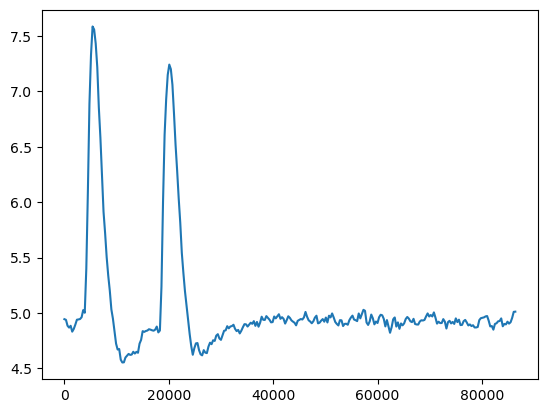

In [119]:
plt.plot(t_eval, x_upd_4s1p[:,3])

array([[ 3.77029340e+07,  3.08334362e+01,  9.58872131e+03,
         1.48889806e+01,  7.21639480e+03,  8.57550024e-24,
         5.24387545e-11],
       [ 3.61192441e+02,  3.26634491e-01,  5.76011862e+00,
         2.26977893e-01,  4.99702154e+00,  1.72258559e-13,
         4.25968282e-07],
       [ 7.48731601e+01,  9.15269243e-02,  2.04934495e+00,
         1.20818617e-01,  4.91371286e+00,  1.49935493e-13,
         3.69488536e-07],
       [ 2.99937325e+01,  2.67674416e-02,  3.98525824e-01,
         1.96598211e-02, -4.91371286e+00, -1.49935493e-13,
        -3.69456310e-07]])

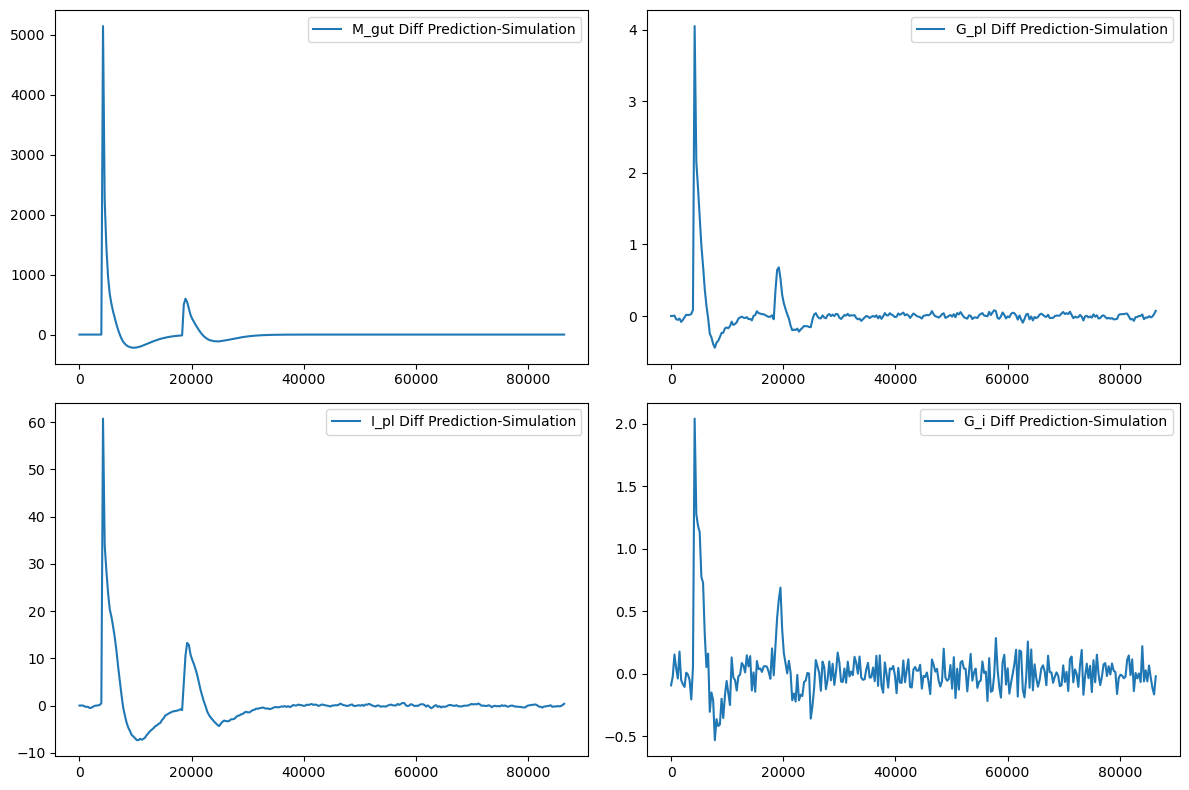

In [120]:
estimate_error(comp_pred_sim_4s1p, t_eval)

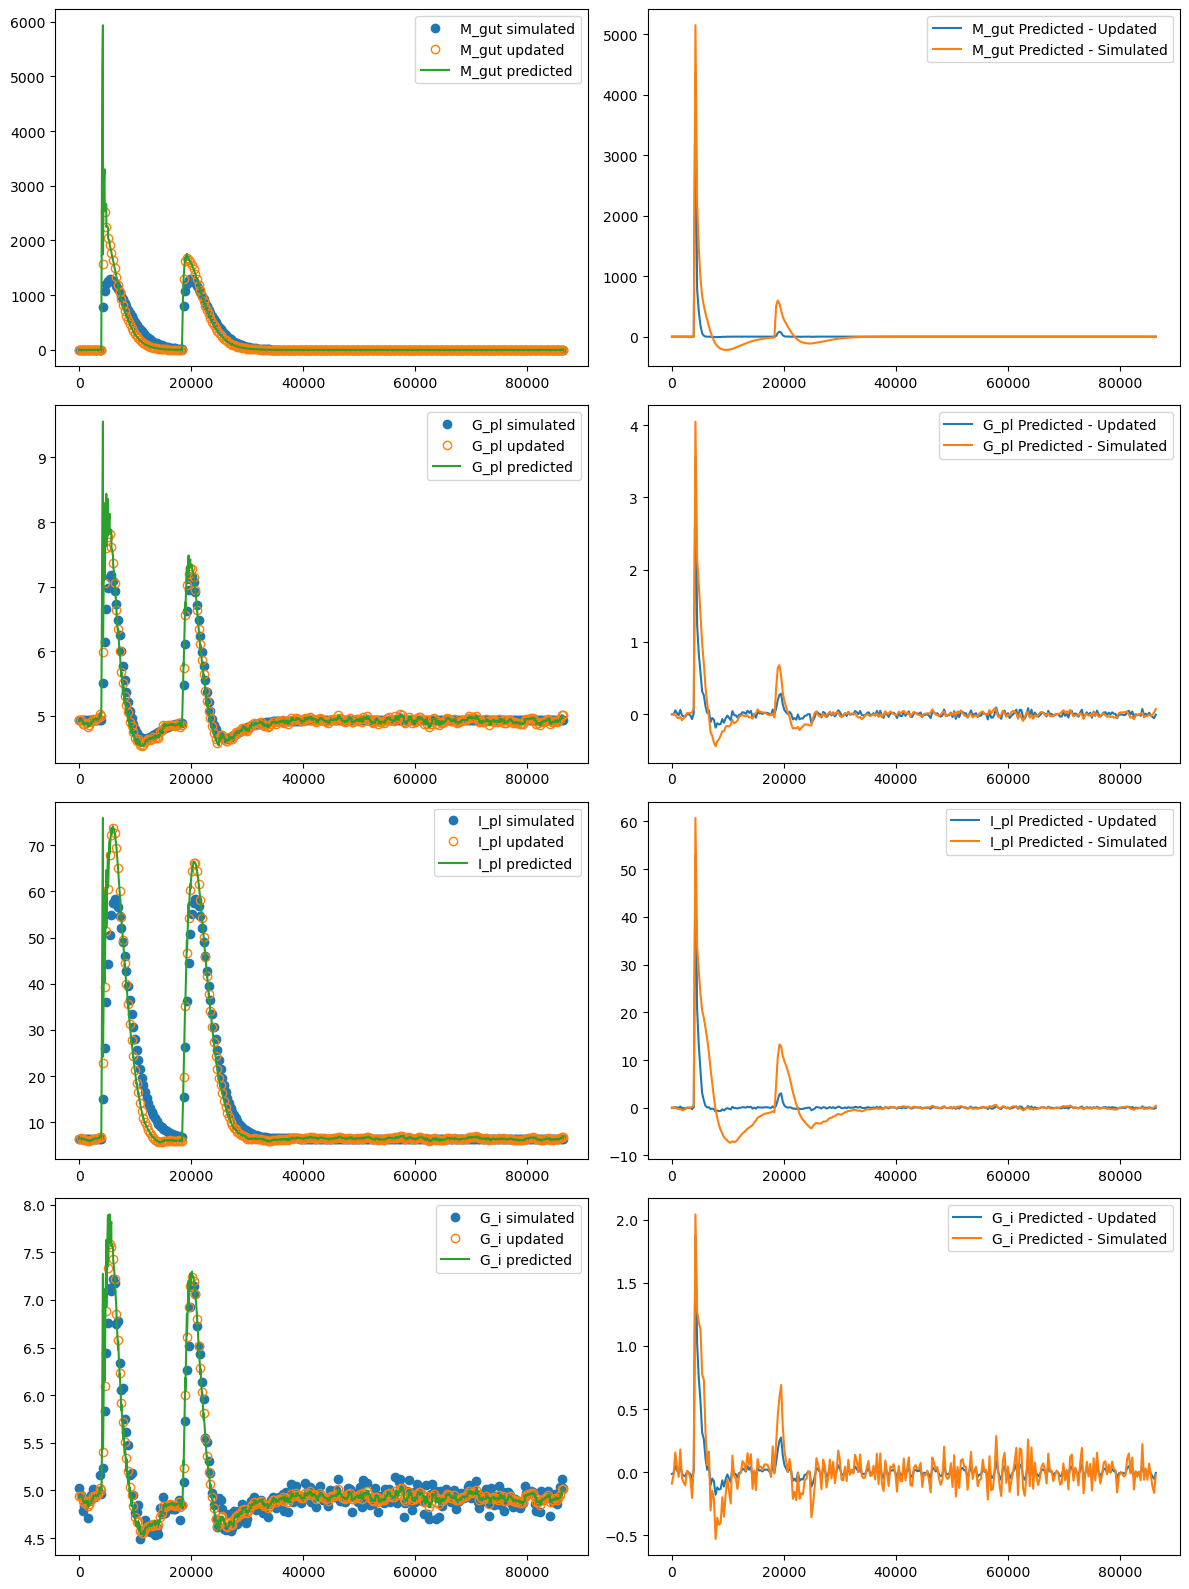

In [121]:
plot_ukf(sim_b, x_upd_4s1p, x_pred_4s1p, t_eval, time_4s1p)

In [122]:
x_pred_4s1p[0], x_pred_4s1p[-1]

(array([ 0.00000000e+00,  4.93000137e+00,  6.50001940e+00,  4.93000000e+00,
        -1.42942893e+00,  1.26666667e-05,  3.00000000e+01]),
 array([-6.44619151e-17,  5.00156803e+00,  6.88537675e+00,  5.00623298e+00,
        -5.29548565e+00,  1.26666664e-05,  2.99999993e+01]))

In [123]:
k1_est = (a_k1 + b_k1)/2 + (b_k1 - a_k1)/np.pi*np.arctan(x_pred_4s1p[:,4])
k5_est = param.k1+x_pred_4s1p[:,5]
tau_g_est = param.tau_g+x_pred_4s1p[:,6]

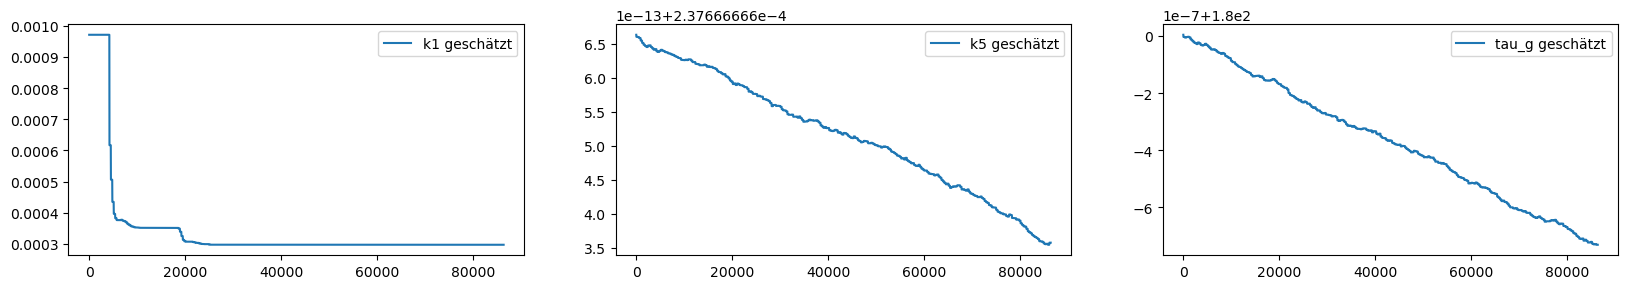

In [124]:
fig, ax = plt.subplots(1,3, figsize = (20,3))

ax[0].plot(time_4s1p, k1_est, label = "k1 geschätzt")
ax[0].legend()

ax[1].plot(time_4s1p, k5_est, label = "k5 geschätzt")
ax[1].legend()

ax[2].plot(time_4s1p, tau_g_est, label = "tau_g geschätzt")
ax[2].legend()

In [125]:
min_k1, max_k1, min_k5, max_k5, min_tau_g, max_tau_g = np.min(k1_est), np.max(k1_est), np.min(k5_est), np.max(k5_est), np.min(tau_g_est), np.max(tau_g_est)
err_k1 = (delta_k1+param.k1)/k1_est[-1] #Vergleich Schätzung mit tatsächlichem Wert
err_k5 = (delta_k5+param.k5)/k5_est[-1] #Vergleich Schätzung mit tatsächlichem Wert
err_tau_g = (delta_tau_g+param.tau_g)/tau_g_est[-1] #Vergleich Schätzung mit tatsächlichem Wert

print(f"(Max, Min) k1: ({max_k1}, {min_k1}), (Max, Min) k5: ({max_k5}, {min_k5}), (Max, Min) tau_g: ({max_tau_g}, {min_tau_g})")
print(f"Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = {err_k1}, k5_sim/k5_pred = {err_k5}, tau_g_sim/tau_g_pred = {err_tau_g}")

(Max, Min) k1: (0.0009715532739510144, 0.0002970041957361044), (Max, Min) k5: (0.00023766666666333016, 0.00023766666635468815), (Max, Min) tau_g: (180.0000000046566, 179.99999926798046)
Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = 0.83318779574657, k5_sim/k5_pred = 0.3197755964885093, tau_g_sim/tau_g_pred = 1.0000000040667754


In [126]:
starterr_k1 = (delta_k1+param.k1)/k1_est[0] #Fehler beim Startwert von k1
starterr_k1

0.2547467099512898

In [127]:
param.k1+delta_k1, k1_est[-1]

(0.0002475, 0.0002970518786562758)

In [128]:
param.k5+delta_k5, k5_est[-1]

(7.599999999999999e-05, 0.00023766666635779678)

In [129]:
param.tau_g+delta_tau_g, tau_g_est[-1]

(180.0, 179.99999926798046)